<a href="https://colab.research.google.com/github/Joseph-Caicedo/Mask_detection/blob/main/Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importar bibliotecas necesarias**

In [ ]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix , classification_report
from imutils import paths
from google.colab import files
import IPython.display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
import os

# **Cargar el conjunto de datos**

Se clona el repositorio principal

In [ ]:
!git clone https://github.com/Joseph-Caicedo/Mask_detection.git

Cloning into 'Mask_detection'...
remote: Enumerating objects: 24445, done.
remote: Total 24445 (delta 0), reused 0 (delta 0), pack-reused 24445
Receiving objects: 100% (24445/24445), 675.35 MiB | 42.02 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Checking out files: 100% (16288/16288), done.


**Nota: Los conjuntos de datos se obtiene del repositorio ["observations"](https://github.com/prajnasb/observations.git) que es propiedad de [Prajna Bhandary](https://github.com/prajnasb), de ["Face-Mask-Detection"](https://github.com/DavidReveloLuna/MaskDetection.git) que es propiedad de [Balaji S
](https://github.com/balajisrinivas) y ["Real-Time-Medical-Mask-Detection"](https://github.com/TheSSJ2612/Real-Time-Medical-Mask-Detection/releases/download/v0.1/Dataset.zip)** 


Se observa el contenido del directorio "Deteccion_Mascarillas"

In [ ]:
!ls Mask_detection

 Artículo_Detección_Macarilla   face_detector		   README.md
 data_1			        mask_classifier_1.py	  'Related Work'
 data_2			        mask_classifier_2.py	   utilities.py
 data_3			        mask_detector.model
 detect_mask_video.py	        model_mobileNetV2.tflite


Se guardan la ruta del conjunto de datos principal y el conjunto de prueba

In [ ]:
data_path = 'Mask_detection/data_2/'
data_dir = os.path.join(data_path)
categories = ["with_mask", "without_mask"]

## **Visualizar algunas imagenes del conjunto de datos** 

Recuento del conjunto de datos

In [ ]:
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

with_mask_fnames = os.listdir( with_mask_dir )
without_mask_fnames = os.listdir( without_mask_dir )

print('Imagenes con mascara ', len(os.listdir(with_mask_dir)))
print('Imagenes sin mascara ', len(os.listdir(without_mask_dir)))

Imagenes con mascara  1915
Imagenes sin mascara  1918


Visualizar algunas de las imagenes del conjunto de datos

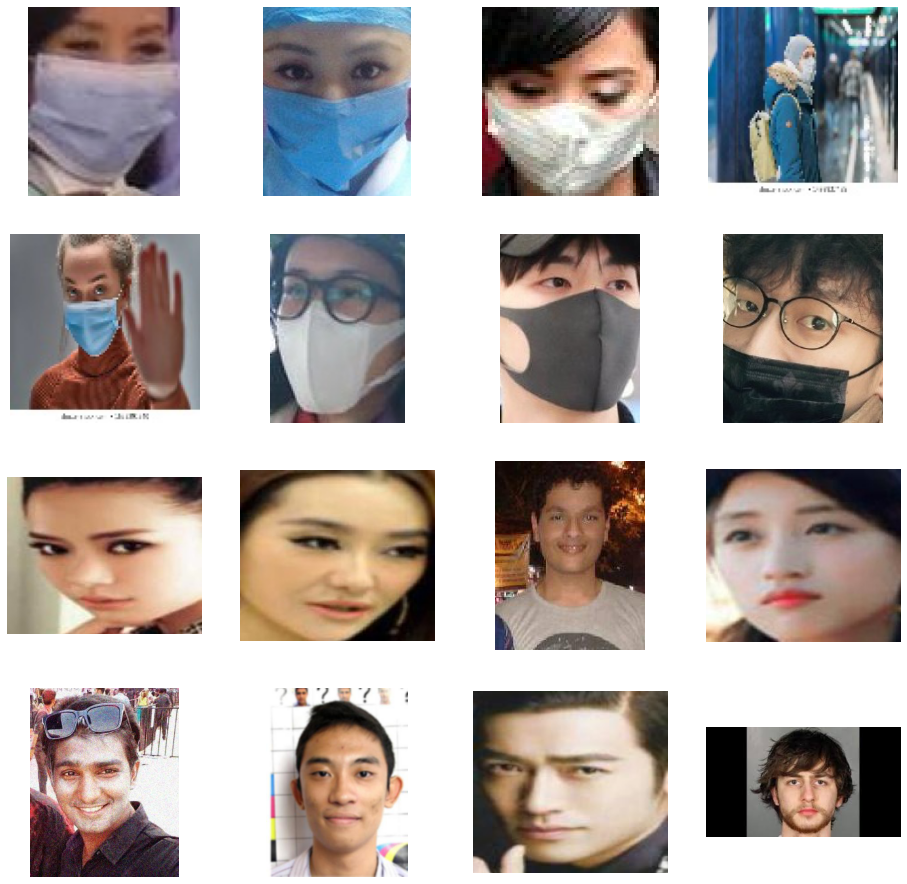

In [ ]:
# Parámetros para nuestro gráfico; emitiremos imágenes en una configuración 4x4
nrows = 4
ncols = 4

pic_index = 0 # Índice para iterar sobre imágenes

# Configure matplotlib fig y ajústelo a fotos de 4x4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_with_mask_pix = [os.path.join(with_mask_dir, fname) 
                for fname in with_mask_fnames[ pic_index-8:pic_index] 
               ]

next_without_mask_pix = [os.path.join(without_mask_dir, fname) 
                for fname in without_mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_with_mask_pix+next_without_mask_pix):
  # Configurar subtrama; los índices de la subparcela comienzan en 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # No mostrar ejes (o líneas de cuadrícula)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# **Preprocesamiento de imagenes**

Dividir el conjunto de datos

In [ ]:
data = []
labels = []

for category in categories:
    path = os.path.join(data_path, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# Realizar una codificación one-hot en las etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=18)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Determinar el tamaño de los lotes

In [ ]:
batch_size = 32

Data Augmentation

In [ ]:
# -----------------
# Aumento de imagen
# -----------------
datagen =ImageDataGenerator(rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

# **Modelos propuesto**

## **Arquitectura**

In [ ]:
mobile = MobileNetV2( weights="imagenet", include_top=False,
	                    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
headModel = mobile.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model_mobileNetV2 = Model(inputs=mobile.input, outputs=headModel)
for layer in mobile.layers:
	layer.trainable = False

In [ ]:
model_mobileNetV2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

Learning rate y epochs

In [ ]:
epochs = 50
lr = 1e-4

Se establece el optimizador y función de perdida

In [ ]:
opt = Adam(lr=lr, decay=lr / epochs)
model_mobileNetV2.compile(loss="binary_crossentropy", optimizer=opt,
                      	metrics=["accuracy"])

## **Entrenamiento**

Ebtrenamiento sin callbacks

In [ ]:
history = model_mobileNetV2.fit(  datagen.flow(trainX, trainY, batch_size=batch_size),
                                  validation_data=(testX, testY),
                                  steps_per_epoch=len(trainX) // batch_size ,
                                  validation_steps=len(testX) // batch_size,
                                  epochs=epochs)

Epoch 1/50
95/95 [==============================] - 34s 330ms/step - loss: 0.5341 - accuracy: 0.7750 - val_loss: 0.1517 - val_accuracy: 0.9674
Epoch 2/50
95/95 [==============================] - 31s 323ms/step - loss: 0.1576 - accuracy: 0.9627 - val_loss: 0.0920 - val_accuracy: 0.9700
Epoch 3/50
95/95 [==============================] - 31s 323ms/step - loss: 0.0844 - accuracy: 0.9804 - val_loss: 0.0740 - val_accuracy: 0.9726
Epoch 4/50
95/95 [==============================] - 31s 324ms/step - loss: 0.0721 - accuracy: 0.9784 - val_loss: 0.0637 - val_accuracy: 0.9778
Epoch 5/50
95/95 [==============================] - 31s 322ms/step - loss: 0.0625 - accuracy: 0.9806 - val_loss: 0.0622 - val_accuracy: 0.9791
Epoch 6/50
95/95 [==============================] - 31s 323ms/step - loss: 0.0523 - accuracy: 0.9874 - val_loss: 0.0564 - val_accuracy: 0.9804
Epoch 7/50
95/95 [==============================] - 31s 322ms/step - loss: 0.0413 - accuracy: 0.9896 - val_loss: 0.0528 - val_accuracy: 0.9817

Rendimiento del modelo

<Figure size 432x288 with 0 Axes>

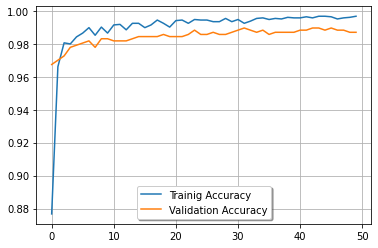

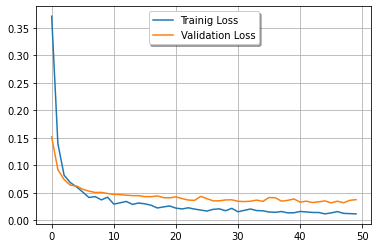

<Figure size 432x288 with 0 Axes>

In [ ]:
#-----------------------------------------------------------
# Recupere una lista de resultados de la lista de conjuntos de datos de 
# entrenamiento y prueba para cada época de entrenamiento
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Obtener número de épocas

#------------------------------------------------
# Trazar la precisión del entrenamiento y la validación por época
#------------------------------------------------
plt.plot  ( epochs, acc, label='Trainig Accuracy' )
plt.plot  ( epochs, val_acc, label='Validation Accuracy' )
legend = plt.legend(loc='lower center', shadow=True, fontsize='medium')
legend.get_frame()
plt.grid()
plt.figure()

#------------------------------------------------
# Trazar pérdida de validación y entrenamiento por época
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Trainig Loss'  )
plt.plot  ( epochs, val_loss, label='Validation Loss')
legend = plt.legend(loc='upper center', shadow=True, fontsize='medium')
legend.get_frame()
plt.grid()
plt.figure()

## **Predicciones**

Prueba con imagenes fuera del conjunto de datos

Saving 1012.jpg to 1012.jpg
Saving 1013.jpg to 1013.jpg
Saving 1014.jpg to 1014.jpg


[0]
No tiene mascarilla


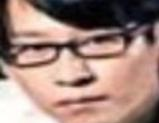



[0]
No tiene mascarilla


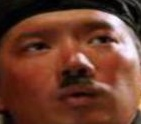



[0]
No tiene mascarilla


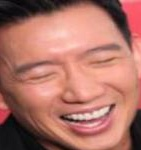

In [ ]:
uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model_mobileNetV2.predict(images, batch_size=batch_size)
  print("\n")

  classes = np.argmax(classes, axis=1)
  print(classes)
  if classes[0]==0:
    print("No tiene mascarilla")  
  else:
    print(" Tiene mascarilla")

  IPython.display.display(IPython.display.Image(path))

##### Confusion Matrix


In [ ]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion matrix')
    plt.ylabel('Truth label')
    plt.xlabel('Predicted label')

In [ ]:
predIdxs = model_mobileNetV2.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

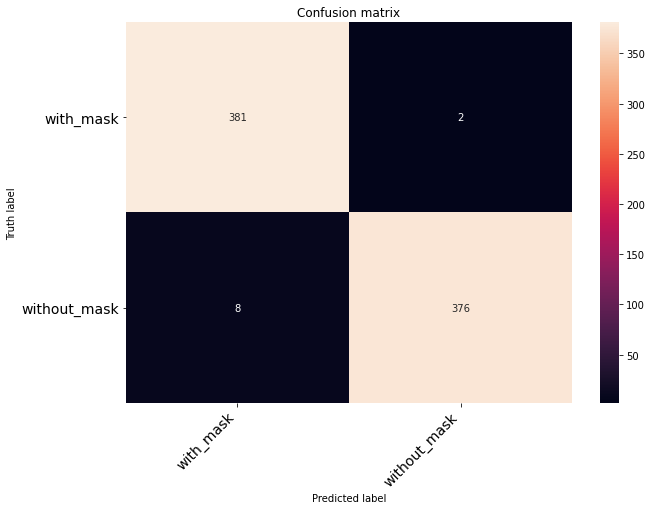

In [ ]:
cm = confusion_matrix(testY.argmax(axis=1) ,predIdxs)
print_confusion_matrix(cm,["with_mask","without_mask"])

In [ ]:
print(classification_report(testY.argmax(axis=1) ,predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



## **ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY.argmax(axis=1), predIdxs)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

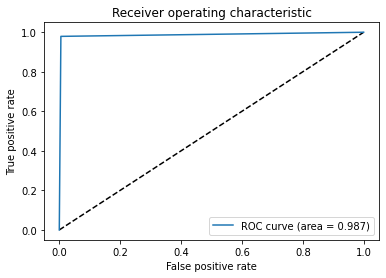

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC curve (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='best')
plt.show()

# **Guardar modelo**

In [ ]:
# Guardar el Modelo
model_mobileNetV2.save("mask_detector.model", save_format="h5")

# Recrea exactamente el mismo modelo solo desde el archivo
# new_model = keras.models.load_model('path_to_my_model.h5')

# **Convertir el modelos a TFLite**

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobileNetV2)
tflite_model_mobileNetV2 = converter.convert()
open("model_mobileNetV2.tflite","wb").write(tflite_model_mobileNetV2)

INFO:tensorflow:Assets written to: /tmp/tmp_xt4hm5b/assets


9516748